In [1]:
!pip install pulp
!pip install yfinance


In [2]:
!pip install cvxpy
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import cvxpy as cp
import scipy.linalg as la
import pulp

## how we load data from yahoo finance

#### Short-term corporate bond data

In [3]:

T = 1 # Number of days in time period
R = []
assets = ["SCHJ","IGSB","VCSH","SPSB","GSIG","ICSH","RATE", "RYSE", "XBIL"]

for bond in assets:
    data = yf.Ticker(bond)
    # 我先改成1年， 这个之后可以随时改成想要的时段
    df = data.history(period="1y")

    # close values on that day
    close = df['Close'].values

    # convert day to day close values to return
    returns = (close[T:] - close[:-T])/close[:-T]
    R.append(returns)

# Return
R = np.array(R).T
# Mean return
r = np.mean(R,axis=0)
# Covariance matrix: a measure of strength of correlation between two variable or more set of variables.
S = np.cov(R.T)

In [4]:
R

array([[ 0.00126159,  0.00099005,  0.0011814 , ..., -0.00517025,
        -0.00058422,  0.00019952],
       [ 0.00178526,  0.00197752,  0.0019665 , ...,  0.00320492,
         0.00662511,  0.00039912],
       [-0.00199159, -0.0025659 , -0.00222443, ...,  0.00561218,
         0.00925278, -0.00019948],
       ...,
       [-0.00104   , -0.00117619, -0.00116995, ...,  0.01079535,
         0.0045183 ,  0.        ],
       [ 0.00110351,  0.00117758,  0.00143155, ..., -0.01991958,
        -0.01212852,  0.        ],
       [-0.00546972, -0.0056851 , -0.00571793, ...,  0.05955404,
         0.03585657,  0.00010012]])

## US Treasury Bond in past 1 years

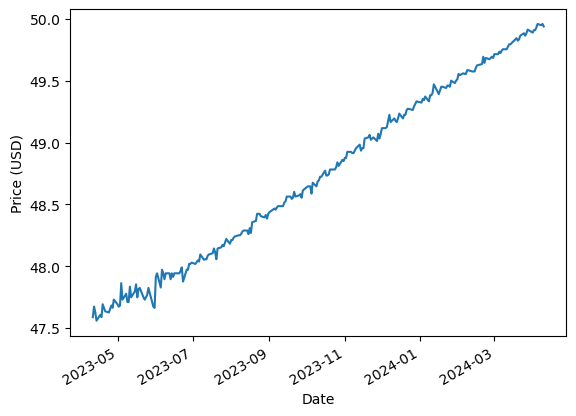

In [5]:
# last df is US Treasury Bond
df['Open'].plot()
plt.ylabel('Price (USD)')
plt.show()

## histogram of US Treasury Bond in past 1 years

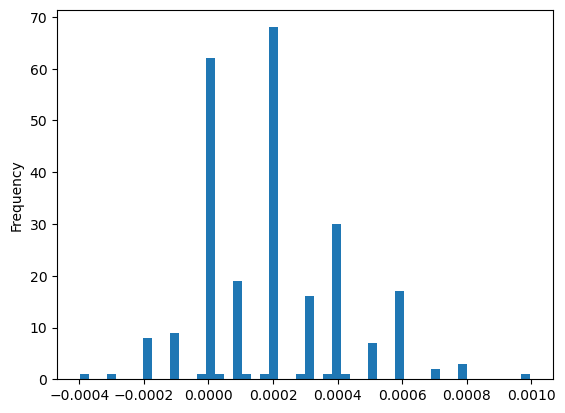

In [6]:
return_XBIL = R[:,-1]
plt.hist(return_XBIL,bins=50)
plt.ylabel('Frequency')
plt.show()

In [7]:
r

array([0.00015513, 0.00015891, 0.0001538 , 0.00017072, 0.00014797,
       0.00021608, 0.00092564, 0.00085387, 0.00019502])

In [8]:
S

array([[ 3.68710769e-06,  3.58992841e-06,  3.52434966e-06,
         2.35187736e-06,  3.58482497e-06,  3.85419739e-07,
        -1.99739730e-05, -1.61434514e-05,  1.44816243e-07],
       [ 3.58992841e-06,  3.77957280e-06,  3.65817879e-06,
         2.43972009e-06,  3.71637345e-06,  3.98393939e-07,
        -1.96498070e-05, -1.68888803e-05,  1.49440478e-07],
       [ 3.52434966e-06,  3.65817879e-06,  3.61305370e-06,
         2.38009599e-06,  3.64781490e-06,  3.96083983e-07,
        -1.97041005e-05, -1.65642401e-05,  1.48267901e-07],
       [ 2.35187736e-06,  2.43972009e-06,  2.38009599e-06,
         1.72967600e-06,  2.42469141e-06,  2.71478615e-07,
        -1.22736571e-05, -1.01978456e-05,  1.04082860e-07],
       [ 3.58482497e-06,  3.71637345e-06,  3.64781490e-06,
         2.42469141e-06,  3.78606161e-06,  3.97550377e-07,
        -2.04488228e-05, -1.69949090e-05,  1.41589230e-07],
       [ 3.85419739e-07,  3.98393939e-07,  3.96083983e-07,
         2.71478615e-07,  3.97550377e-07,  1.001954

# We consider risk as MAD first, all these models are model 1x




# model 1A
when we minimize MAD under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
&  \sum_j x_j r_j = r_0 \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [9]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
r0 = 0.0008
print(n,T,r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob +=  - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob += lpSum(r[j] * x[j] for j in range(n)) == r0

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


9 251 0.0008
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/fb46dfa4a0a94fcc86346fe9a5b8fddb-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/fb46dfa4a0a94fcc86346fe9a5b8fddb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 5799 RHS
At line 6304 BOUNDS
At line 6305 ENDATA
Problem MODEL has 504 rows, 260 columns and 5038 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 495 (-9) rows, 260 (0) columns and 4948 (-90) elements
Perturbing problem by 0.001% of 0.0064707063 - largest nonzero change 4.9862999e-05 ( 38.41221%) - largest zero change 4.0815914e-05
0  Obj -0 Primal inf 0.43376535 (2)
44  Obj -0.00027576778 Primal inf 624.19993 (246)
108  Obj -0.0013594873 Primal inf 315.82957 (222)
156  Obj -0.0022205276 Primal inf 143.0004 (175)
218  Obj

# model 1B
when we maximize return under a specified MAD constrait $m_0$
$$
\begin{gathered}
\operatorname{maximize} \sum_j x_j r_j  \\
\text { subject to } \sum_j x_j=1 \\
  \frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \leq m_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{gathered}
& \operatorname{maximize}  \sum_j x_j r_j   \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& \frac{1}{T} \sum_{t=1}^T y_t \leq m_0  \\
& x_j \geq 0 \quad j=1,2, \ldots, n, \\
& r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$





In [10]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
m0 = 0.007
print(n,T,r0)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob +=  (1/T) * lpSum(y[t] for t in range(T)) <= m0, "Risk"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


9 251 0.0008
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/0be2000234014576a6978cc6c402472c-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/0be2000234014576a6978cc6c402472c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 5799 RHS
At line 6304 BOUNDS
At line 6305 ENDATA
Problem MODEL has 504 rows, 260 columns and 5280 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 495 (-9) rows, 260 (0) columns and 5190 (-90) elements
Perturbing problem by 0.001% of 0.076455196 - largest nonzero change 0.00034093376 ( 10.904877%) - largest zero change 9.9786582e-05
0  Obj -0 Primal inf 21.414482 (2) Dual inf 0.14674726 (9)
84  Obj 0.0023804251 Primal inf 181.64992 (170)
123  Obj 0.0021418542 Primal inf 58.798734 (130)
161  Obj 0.00052514226 Primal inf 57.

## model 1C
when combine return and risk together with $\mu$

$$
\begin{gathered}
\operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T\left|\sum_j x_j\left(R_j(t)-r_j\right)\right| \\
\text { subject to } \sum_j x_j=1 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

The LP version is
$$
\begin{aligned}
& \operatorname{maximize} \mu \sum_j x_j r_j-\frac{1}{T} \sum_{t=1}^T y_t \\
& \text { subject to }-y_t \leq \sum_j x_j\left(R_j(t)-r_j\right) \leq y_t \quad t=1,2, \ldots, T \text {, } \\
& \sum_j x_j=1 \\
& x_j \geq 0 \quad j=1,2, \ldots, n \\
& y_t \geq 0 \quad t=1,2, \ldots, T . \\
&
\end{aligned}
$$

below is pulp implementation

In [11]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods
mu = 1
print(n,T,mu)


# Create a LP problem
prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

# Define decision variables
x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

# Define objective function
prob += lpSum(r[j] * x[j] for j in range(n)) * mu - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

# Define constraints
for t in range(T):
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
    prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

prob += lpSum(x) == 1, "Sum_of_weights"

# Solve the problem
prob.solve()

# Print the results
print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


9 251 1
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/7cd4fa19745844f4ac432d2373001b28-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/7cd4fa19745844f4ac432d2373001b28-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 508 COLUMNS
At line 5798 RHS
At line 6302 BOUNDS
At line 6303 ENDATA
Problem MODEL has 503 rows, 260 columns and 5029 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 494 (-9) rows, 260 (0) columns and 4939 (-90) elements
Perturbing problem by 0.001% of 0.046490556 - largest nonzero change 8.1686428e-05 ( 38.427581%) - largest zero change 0
0  Obj -0 Primal inf 0.097929434 (1) Dual inf 0.099500554 (9)
51  Obj 0.00069064337 Primal inf 194.26322 (217)
98  Obj 0.00036281029 Primal inf 51.564527 (233)
149  Obj 0.00019124747 Primal inf 143.85773 (241)


# Efficient frontier

Let us use model 1B to compute the efficient frontier

In [12]:
from pulp import *

# Define the data
n = len(assets)  # Number of assets
T = len(R[:,0])  # Number of time periods

m0_array = np.linspace(0.0,0.01,50)
risk_array = 0. * m0_array
i = 0
for i in range(len(m0_array)):

  # Define the data
  n = len(assets)  # Number of assets
  T = len(R[:,0])  # Number of time periods
  r0 = m0_array[i]

  # Create a LP problem
  prob = LpProblem("Financial_Portfolio_Optimization", LpMaximize)

  # Define decision variables
  x = [LpVariable(f"x{j}", lowBound=0) for j in range(n)]
  y = [LpVariable(f"y{t}", lowBound=0) for t in range(T)]

  # Define objective function
  prob +=  - (1/T) * lpSum(y[t] for t in range(T)), "Objective"

  # Define constraints
  for t in range(T):
      prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) <= y[t], f"Upper_constraint_{t}"
      prob += lpSum(x[j] * (R[t][j] - r[j]) for j in range(n)) >= -y[t], f"Lower_constraint_{t}"

  prob += lpSum(r[j] * x[j] for j in range(n)) == r0

  prob += lpSum(x) == 1, "Sum_of_weights"

  # Solve the problem
  prob.solve()
  risk_array[i] = value( (1/T) * lpSum(y[t] for t in range(T)))

print("Status:", LpStatus[prob.status])
print("Optimal Portfolio Weights:")
for j in range(n):
    print(f"x{j}: {value(x[j])}")
print("expected return (MAD):", value(lpSum(r[j] * x[j] for j in range(n))))
print("Mean Absolute Deviation (MAD):", value( (1/T) * lpSum(y[t] for t in range(T))))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/e814a7f4042640e49c3894c57d3c16be-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/e814a7f4042640e49c3894c57d3c16be-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 509 COLUMNS
At line 5799 RHS
At line 6304 BOUNDS
At line 6305 ENDATA
Problem MODEL has 504 rows, 260 columns and 5038 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
Perturbing problem by 0.001% of 0.0064707063 - largest nonzero change 4.9933419e-06 ( 3.8438652%) - largest zero change 4.6133043e-06
0  Obj -0 Primal inf 0.097930334 (1)
37  Obj -7.3455227e-05 Primal inf 181.29904 (245)
88  Obj -0.00030281551 Primal inf 116.69154 (226)
132  Ob

In [13]:
print(T)

251


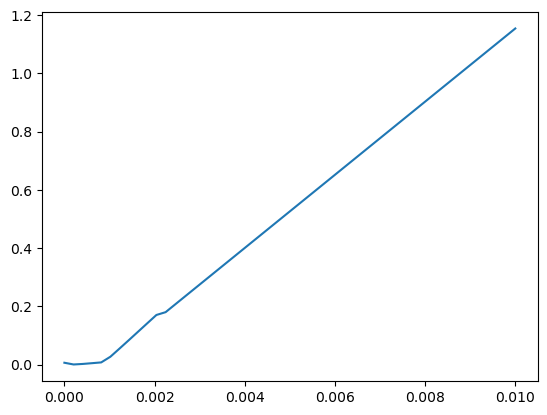

In [14]:
plt.figure()
plt.plot(m0_array, risk_array)

# Now we consider risk as total variance of the portfolio, all these models are model 2x


# model 2A
when we minimize variance under a specified expected return $r_0$
$$
\begin{gathered}
\operatorname{maximize} -\frac{1}{T} \sum_{t=1}^T\left(\sum_j x_j\left(R_j(t)-r_j\right)\right)^2 \\
\text { subject to } \sum_j x_j=1 \\
  \sum_j x_j r_j = r_0 \\
x_j \geq 0 \quad j=1,2, \ldots, n, \\
r_j=\frac{1}{T} \sum_{t=1}^T R_j(t)
\end{gathered}
$$

In [15]:
# centered return
T = 251
R_c = 0. * R
for j in range(len(R[0,:])):
  R_c[:,j] = R[:,j] - r[j]

#print(np.outer(R_c[0,:],R_c[0,:]))
R_c.T @ R_c

# compute the convariance matrix manually
sig = 0. * S
for i in range(len(R[:,0])):
  sig = sig + np.outer(R_c[i,:],R_c[i,:])
sig = sig / T


r0 = 0.0008
n = len(R[0,:])
e = np.ones((n,1))
rq = r.reshape(n,1)

X = cp.Variable((n,1))
Objective = cp.Minimize(cp.quad_form(X,sig))
constraints = [e.T@X == 1, X >= 0, rq.T@X >= r0]
problem = cp.Problem(Objective,constraints)

result = problem.solve()

print(X)


var1


In [16]:
print("expected portfolio", X.value.T)
print("expected return :", (rq.T @ X.value)[0] )
print("Mean variance:", (X.value.T @ sig @ X.value)[0] )

expected portfolio [[1.43653151e-18 7.84477011e-02 1.60040542e-18 1.21442581e-18
  1.70359308e-18 2.52026650e-19 8.99388605e-03 9.12558413e-01
  7.52418322e-19]]
expected return : [0.0008]
Mean variance: [8.59092317e-05]


## Optimization Problem

Choose a risk tolerance $q > 0$:

\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} - q \mathbf{r}^T \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{x} \geq 0 \\
\end{align*}

In [17]:
n = len(assets)
q = 0.1
e = np.ones(n)
X = cp.Variable(n)

obj = cp.Minimize(cp.quad_form(X,S) - q*r@X)
constraints = [e@X == 1, X >= 0]
problem = cp.Problem(obj,constraints)

result = problem.solve()
X.value

array([0.10692883, 0.12404601, 0.10848291, 0.07316007, 0.09985041,
       0.09512154, 0.01372243, 0.3527809 , 0.02590695])

## Optimization Problem

\begin{align*}
\text{minimize:} \ \ & \mathbf{x}^T \Sigma \mathbf{x} \\
\text{subject to:} \ \ & \mathbf{e}^T \mathbf{x} = 1 \\
& \mathbf{r}^T \mathbf{x} = \mu \\
& \mathbf{x} \geq 0 \\
\end{align*}

case mu = 0.01,   minimize risk sigma = 0.001

case mu = 0.02,  minimize risk sigma = 0.003

case mu = 0.05,  minimize risk  sigma = 0.010



In [18]:
n = len(assets)
e = np.ones((n,1))
r = r.reshape(n,1)
mu = 0.001

M = np.block([[2*S,-r,-e],[r.T,0,0],[e.T,0,0]])
b = np.block([[np.zeros((n,1))],[mu],[1]])

x = la.solve(M,b)
print(x)

[[ 1.41374324e-01]
 [ 7.61613497e+00]
 [-3.99684348e-01]
 [-5.80560328e+00]
 [-1.22642447e+00]
 [ 1.41978580e+01]
 [-1.68075864e-02]
 [ 8.85885937e-01]
 [-1.43927336e+01]
 [ 8.33266804e-02]
 [-1.72746198e-05]]
